In [1]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [2]:
import lib.custom_metrics as metrics
import lib.evaluation as ev
import lib.plotting as plot
import lib.models as models
import lib.dataset as dt

import matplotlib.pyplot as plt
import imgaug.augmenters as iaa
import tensorflow as tf
import pandas as pd
import numpy as np
import datetime
import os

from importlib import reload

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPU


## Dataset parameters

In [4]:
DR_LEVELS_PER_CLASS = [[0], [1], [2,3,4]]

# Specify dataset files
TRAIN_FILE = 'DATASET-TRAIN-80.csv'
VALIDATION_FILE = 'DATASET-VALIDATION-10.csv'
TEST_FILE = 'DATASET-TEST-10.csv'

TRAINING_BATCH_SIZE = 4
TRAINING_DATA_AUG = True
TRAINING_BALANCED = True
TRAINING_SHUFFLE = True
TRAINING_PREFETCH = 2
TRAINING_TAKE_SIZE = None

VALIDATION_BATCH_SIZE = 1
VALIDATION_DATA_AUG = False
VALIDATION_BALANCED = True
VALIDATION_SHUFFLE = False
VALIDATION_PREFETCH = 2
VALIDATION_TAKE_SIZE = None

TEST_BATCH_SIZE = 1
TEST_DATA_AUG = False
TEST_BALANCED = False
TEST_SHUFFLE = False
TEST_PREFETCH = 2
TEST_TAKE_SIZE = None

In [5]:
# Prepare datasets
# See 'sample datasets info.txt' to check datasets distribution
reload(dt)

'''
def create_dataset_new(csv_file, 
                        list_list_classes,
                        balanced=False,
                        apply_data_augmentation=False,
                        batch_size=1, 
                        prefetch_buffer=None, 
                        shuffle=False,
                        size=None):
'''

train_dataset, y_true_train = dt.create_dataset_new(TRAIN_FILE, 
                                                    DR_LEVELS_PER_CLASS, 
                                                    balanced=TRAINING_BALANCED, 
                                                    apply_data_augmentation=TRAINING_DATA_AUG, 
                                                    batch_size=TRAINING_BATCH_SIZE, 
                                                    prefetch_buffer=TRAINING_PREFETCH, 
                                                    shuffle=TRAINING_SHUFFLE,
                                                    size=TRAINING_TAKE_SIZE)

val_dataset, y_true_val = dt.create_dataset_new(VALIDATION_FILE, 
                                                DR_LEVELS_PER_CLASS, 
                                                balanced=VALIDATION_BALANCED,
                                                apply_data_augmentation=VALIDATION_DATA_AUG,
                                                batch_size=VALIDATION_BATCH_SIZE,
                                                prefetch_buffer=VALIDATION_PREFETCH, 
                                                shuffle=VALIDATION_SHUFFLE, 
                                                size=VALIDATION_TAKE_SIZE)

test_dataset, y_true_test = dt.create_dataset_new(TEST_FILE, 
                                                  DR_LEVELS_PER_CLASS, 
                                                  balanced=TEST_BALANCED,
                                                  apply_data_augmentation=TEST_DATA_AUG,
                                                  batch_size=TEST_BATCH_SIZE,
                                                  prefetch_buffer=TEST_PREFETCH, 
                                                  shuffle=TEST_SHUFFLE, 
                                                  size=TEST_TAKE_SIZE)

# train_dataset, y_true_train = dt.create_dataset(train, num_classes=3, balanced=True, apply_data_augmentation=True, batch_size=4, prefetch_buffer=2, shuffle=True)
# val_dataset, y_true_val = dt.create_dataset(val, num_classes=3, prefetch_buffer=2, balanced=True, shuffle=False)
# test_dataset, y_true_test = dt.create_dataset(test, num_classes=3, prefetch_buffer=2)

This balanced dataset will have 12147 images, having 4049 images per class
This balanced dataset will have 1566 images, having 522 images per class


In [6]:
# Define model
reload(models)

# model = models.mobileNetV2.get_model(input_shape=(540,540,3), num_outputs=3)
model = models.efficientNetB5.get_model(input_shape=(540,540,3), num_outputs=len(DR_LEVELS_PER_CLASS))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb5 (Functional)  (None, 2048)              28513527  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 3)                 6147      
Total params: 28,519,674
Trainable params: 28,346,931
Non-trainable params: 172,743
_________________________________________________________________


In [7]:
# Load weights if they were saved
base_path = 'saved_weights/efficientNetB5/SGD/'
save_path = base_path + 'model.h5'

if not os.path.exists(base_path):
    os.mkdir(base_path)

if os.path.exists(save_path):
    model.load_weights(save_path)
    print('Model loaded')

In [8]:
# Save ground truth for validation dataset
np.save(base_path + 'ground_truth_val.npy', y_true_val)

In [9]:
# Compile model
reload(metrics)

classes_names = [''.join(list(map(str,class_))) for class_ in DR_LEVELS_PER_CLASS]

metric_AUC_0_1234 = metrics.Wrapper_AUC(classes=[1,2], original_dr_lvls=classes_names)
metric_AUC_01_234 = metrics.Wrapper_AUC(classes=[2], original_dr_lvls=classes_names)
metric_Sp_at_95_Sens_0_1234 = metrics.Wrapper_SpecificityAtSensitivity(sensitivity=0.95, classes=[1,2], original_dr_lvls=classes_names)
metric_Sp_at_95_Sens_01_234 = metrics.Wrapper_SpecificityAtSensitivity(sensitivity=0.95, classes=[2], original_dr_lvls=classes_names)

In [10]:
# Create callbacks
logdir = os.path.join("logs", 'SGD_' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1, write_graph=False)

cbacks = [tf.keras.callbacks.ModelCheckpoint(base_path + 'best' + metric_AUC_0_1234.get_custom_name() + '.h5', 
                                             monitor='val_' + metric_AUC_0_1234.get_custom_name(),
                                             save_best_only=True,
                                             save_weights_only=True,
                                             mode='max'),
          tf.keras.callbacks.ModelCheckpoint(base_path + 'best' + metric_AUC_01_234.get_custom_name() + '.h5', 
                                             monitor='val_' + metric_AUC_01_234.get_custom_name(),
                                             save_best_only=True,
                                             save_weights_only=True,
                                             mode='max'),
          tf.keras.callbacks.ModelCheckpoint(base_path + 'best' + metric_Sp_at_95_Sens_0_1234.get_custom_name() + '.h5', 
                                             monitor='val_' + metric_Sp_at_95_Sens_0_1234.get_custom_name(),
                                             save_best_only=True,
                                             save_weights_only=True,
                                             mode='max'),
          tf.keras.callbacks.ModelCheckpoint(base_path + 'best' + metric_Sp_at_95_Sens_01_234.get_custom_name() + '.h5', 
                                             monitor='val_' + metric_Sp_at_95_Sens_01_234.get_custom_name(),
                                             save_best_only=True,
                                             save_weights_only=True,
                                             mode='max'),
          tf.keras.callbacks.ModelCheckpoint(base_path + 'best_loss.h5',
                                             monitor='val_loss',
                                             save_best_only=True,
                                             save_weights_only=True,
                                             mode='min'),
          tensorboard_callback]

# cbacks = [tensorboard_callback]

In [11]:
# See Tensorboard
%tensorboard --logdir logs

In [12]:
# Train model

validation_dir = base_path+'validation_outputs/'

if not os.path.exists(validation_dir):
    os.mkdir(validation_dir)

model.compile(loss='categorical_crossentropy', 
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, clipnorm=1.0), 
              metrics=[metric_AUC_0_1234, # DR levels: 0 vs 1,2,3,4
                       metric_AUC_01_234, # DR levels: 0,1 vs 2,3,4
                       metric_Sp_at_95_Sens_0_1234, # DR levels: 0 vs 1,2,3,4
                       metric_Sp_at_95_Sens_01_234, # DR levels: 0,1 vs 2,3,4
                       metrics.RunningValidation(path=validation_dir) # THIS METRIC MUST BE INIZIALIZATED BEFORE EVERY TRAINING
                      ]) 

num_epochs = 2000

history = model.fit(train_dataset, epochs=num_epochs, validation_data=val_dataset, verbose=1, callbacks=cbacks)

Epoch 1/2000
   1/3037 [..............................] - ETA: 3s - loss: 1.1576 - AUC_DRlvls_0_1234: 0.0000e+00 - AUC_DRlvls_01_234: 0.0000e+00 - Sp_at_95_sens_DRlvls_0_1234: 0.0000e+00 - Sp_at_95_sens_DRlvls_01_234: 0.0000e+00 - RunningValidation: 0.0000e+00WARNING:tensorflow:From /home/alumno/miguel_herrera/lib/python3.8/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
3037/3037 [==============================] - 1587s 523ms/step - loss: 0.4044 - AUC_DRlvls_0_1234: 0.9658 - AUC_DRlvls_01_234: 0.9665 - Sp_at_95_sens_DRlvls_0_1234: 0.8681 - Sp_at_95_sens_DRlvls_01_234: 0.9033 - RunningValidation: 0.0000e+00 - val_loss: 3.0951 - val_AUC_DRlvls_0_1234: 0.1921 - val_AUC_DRlvls_01_234: 0.5104 - val_Sp_at_95_sens_DRlvls_0_1234: 0.0000e+00 - val_Sp_at_95_sens_DRlvls_01_234: 0.0785 - val_RunningValidation: 1.0000
E

KeyboardInterrupt: 

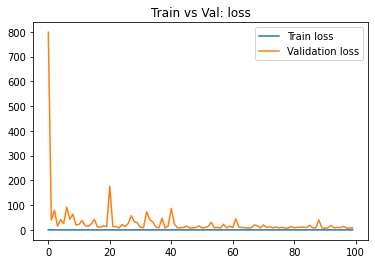

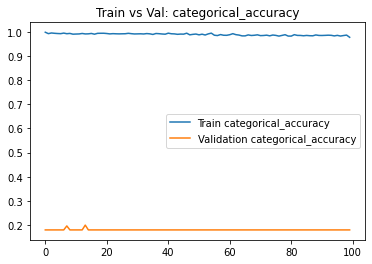

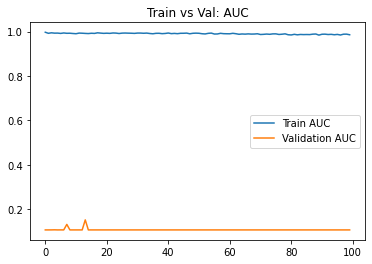

In [12]:
# Plot metrics - 0 1 234 balanced y SGD
plot.plot_metric(history, 'loss')
plot.plot_metric(history, 'categorical_accuracy')
plot.plot_metric(history, 'AUC')

In [ ]:
# Plot metrics - 0 1 234 balanced y SGD
plot.plot_metric(history, 'loss')
plot.plot_metric(history, 'categorical_accuracy')
plot.plot_metric(history, 'AUC')

# DE AQUI PARA ABAJO QUEDA PENDIENTE HASTA SER ADAPTADO

In [13]:
# Validation predictions
y_pred_val = model.predict(val_dataset)

# Test predictions
y_pred_test = model.predict(test_dataset)

In [38]:
%%time

# Get ROC curves
reload(ev)

# 1 and 2: DR lvl 1 and DR lvls 2,3,4
# 2: DR lvls 2,3,4
classes = [(1,2), 2]
classes = None # NO FUNCIONA --- REVISAR

fpr_val, tpr_val, thr_val = ev.get_roc_curve(y_true_val[:,:-1], y_pred_val, classes=classes, num_thresholds=200, remove_intermediate_points=False, remove_under_ROC_points=False)
print('---')
fpr_val, tpr_test, thr_test = ev.get_roc_curve(y_true_test[:,:-1], y_pred_test, classes=classes, num_thresholds=200, remove_intermediate_points=False, remove_under_ROC_points=False)

(200,)
Se han recorrido 199
(200,)
Se han recorrido 199
(200,)
Se han recorrido 199
---
(200,)
Se han recorrido 199
(200,)
Se han recorrido 199
(200,)
Se han recorrido 199
CPU times: user 14 s, sys: 0 ns, total: 14 s
Wall time: 14 s


In [49]:
np.sort(y_pred_val[:,2])

array([0.9997912 , 0.9997912 , 0.9997912 , ..., 0.99979144, 0.99979144,
       0.99979144], dtype=float32)

In [50]:
import lib.custom_metrics as metrics

In [51]:
m = metrics.Wrapper_SpecificityAtSensitivity(0.95, classes=[2])

m.update_state(y_true_val, y_pred_val)

m.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.0>

/home/alumno/Escritorio/Retinopathy/lib/evaluation.py:266: RuntimeWarning: invalid value encountered in double_scalars
  A_v = v[1] / v[0] # m
/home/alumno/Escritorio/Retinopathy/lib/evaluation.py:270: RuntimeWarning: invalid value encountered in double_scalars
  A_n = n[1] / n[0] # m
/home/alumno/Escritorio/Retinopathy/lib/evaluation.py:266: RuntimeWarning: invalid value encountered in double_scalars
  A_v = v[1] / v[0] # m
/home/alumno/Escritorio/Retinopathy/lib/evaluation.py:270: RuntimeWarning: invalid value encountered in double_scalars
  A_n = n[1] / n[0] # m


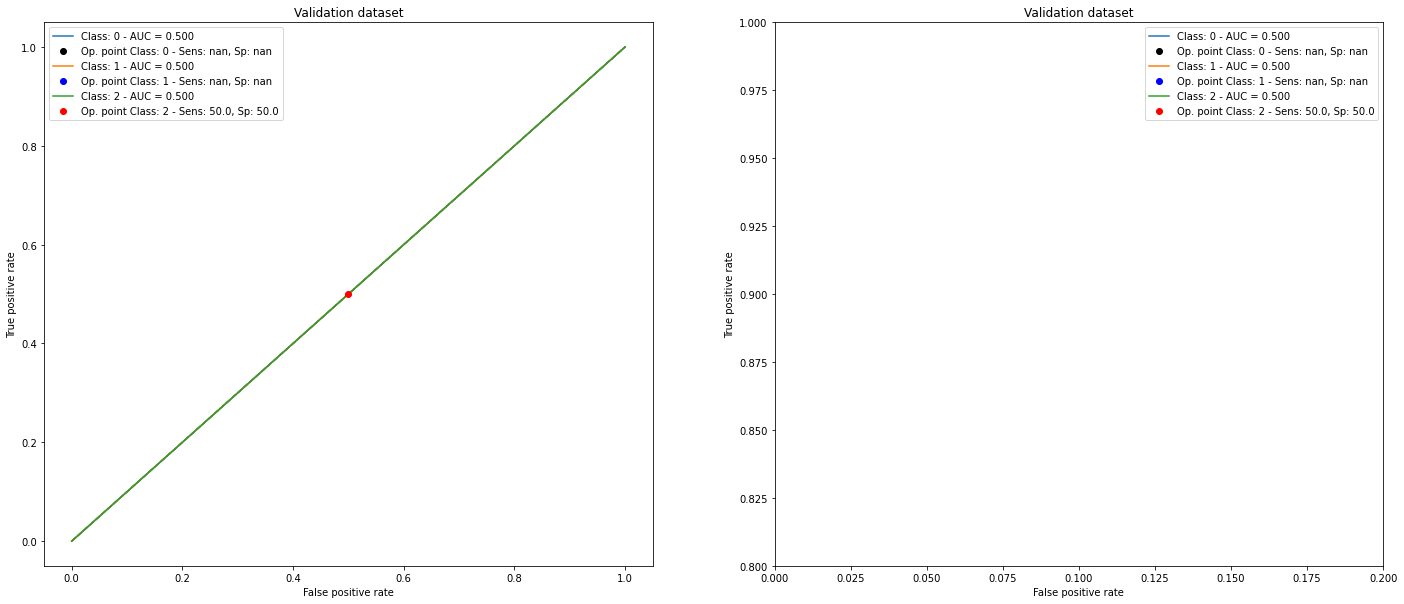

In [40]:
reload(plot)
plot.plot_roc_curve(fpr_val, tpr_val, thr_val, 'Validation dataset', list('012'), operative_threshold=None, grid=False, show_points=False)

In [25]:
# Get closest points to 0,1 in validation ROCs
val_thr_closests = []
for i in range(len(fpr_val)):
    _, _, th = ev.find_closest_point_to_01(fpr_val[i], tpr_val[i], thr_val[i])
    val_thr_closests.append(th)
val_thr_closests = [tuple(val_thr_closests)]

In [26]:
# Operative points
reload(ev)
dr_levels, dr_classifications = ev.get_dr_levels_and_classifications_per_classes(y_true_val, classes=classes)

# Sensibility operative points 
operative_sens_points = [98, 95, 93, 90, 85]

results_val = ev.get_results_at_operative_points(fpr_val,
                                                 tpr_val,
                                                 thr_val,
                                                 y_pred_val,
                                                 dr_levels,
                                                 dr_classifications,
                                                 operative_sens_points,
                                                 operative_thresholds=val_thr_closests)

class_ = 0
results_val[class_].style.set_caption('Validation dataset - Class ' + str(classes[class_]) + ' - AUC: ' + str(round(ev.get_auc(fpr_val[class_], tpr_val[class_]), 4)))

,Sens. Operative point,Sensibility,Specificity,False negative rate,FNR_0 (sample),Thresholds
0,98,98.000000,2.000000,2.000000,0.000000,0.020000
1,95,95.000000,5.000000,5.000000,0.000000,0.050000
2,93,93.000000,7.000000,7.000000,0.000000,0.070000
3,90,90.000000,10.000000,10.000000,0.000000,0.100000
4,85,85.000000,15.000000,15.000000,0.000000,0.150000
5,Closest point,50.000000,50.000000,50.000000,0.000000,0.500000


In [27]:
class_ = 1
results_val[class_].style.set_caption('Validation dataset - Class ' + str(classes[class_]) + ' - AUC: ' + str(round(ev.get_auc(fpr_val[class_], tpr_val[class_]), 4)))

,Sens. Operative point,Sensibility,Specificity,False negative rate,FNR_1 (sample),Thresholds
0,98,98.000000,2.000000,2.000000,100.000000,0.020000
1,95,95.000000,5.000000,5.000000,100.000000,0.050000
2,93,93.000000,7.000000,7.000000,100.000000,0.070000
3,90,90.000000,10.000000,10.000000,100.000000,0.100000
4,85,85.000000,15.000000,15.000000,100.000000,0.150000
5,Closest point,50.000000,50.000000,50.000000,100.000000,0.500000


In [29]:
# Operative points
dr_levels, dr_classifications = ev.get_dr_levels_and_classifications_per_classes(y_true_test, classes=classes)

# Get thresholds from Validation ROCs
operative_thresholds = [res['Thresholds'] for res in results_val]
operative_thresholds = [e for e in zip(*operative_thresholds)]


results_test = ev.get_results_at_operative_points(fpr_test,
                                                 tpr_test,
                                                 thr_test,
                                                 y_pred_test,
                                                 dr_levels,
                                                 dr_classifications,
                                                 operative_thresholds=operative_thresholds)

class_ = 0
results_test[class_].style.set_caption('Test dataset - Class ' + str(classes[class_]) + ' - AUC: ' + str(round(ev.get_auc(fpr_test[class_], tpr_test[class_]), 4)))

,Sensibility,Specificity,False negative rate,FNR_0 (sample),Thresholds
0,98.000000,2.000000,2.000000,0.000000,0.020000
1,95.000000,5.000000,5.000000,0.000000,0.050000
2,93.000000,7.000000,7.000000,0.000000,0.070000
3,90.000000,10.000000,10.000000,0.000000,0.100000
4,85.000000,15.000000,15.000000,0.000000,0.150000
5,50.000000,50.000000,50.000000,0.000000,0.500000


In [30]:
class_ = 1
results_test[class_].style.set_caption('Test dataset - Class ' + str(classes[class_]) + ' - AUC: ' + str(round(ev.get_auc(fpr_test[class_], tpr_test[class_]), 4)))

,Sensibility,Specificity,False negative rate,FNR_1 (sample),Thresholds
0,98.000000,2.000000,2.000000,100.000000,0.020000
1,95.000000,5.000000,5.000000,100.000000,0.050000
2,93.000000,7.000000,7.000000,100.000000,0.070000
3,90.000000,10.000000,10.000000,100.000000,0.100000
4,85.000000,15.000000,15.000000,100.000000,0.150000
5,50.000000,50.000000,50.000000,100.000000,0.500000


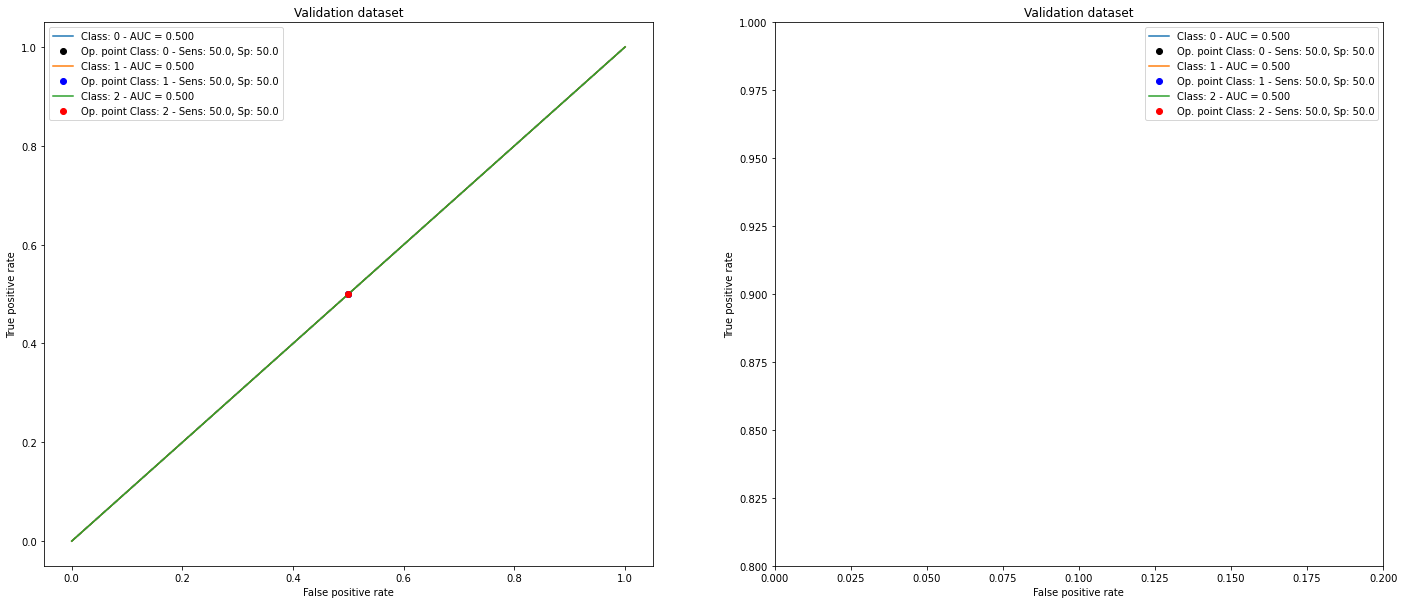

In [32]:
reload(plot)
plot.plot_roc_curve(fpr_val, tpr_val, thr_val, 'Validation dataset', list('012'), operative_threshold=None, grid=False, show_points=False)

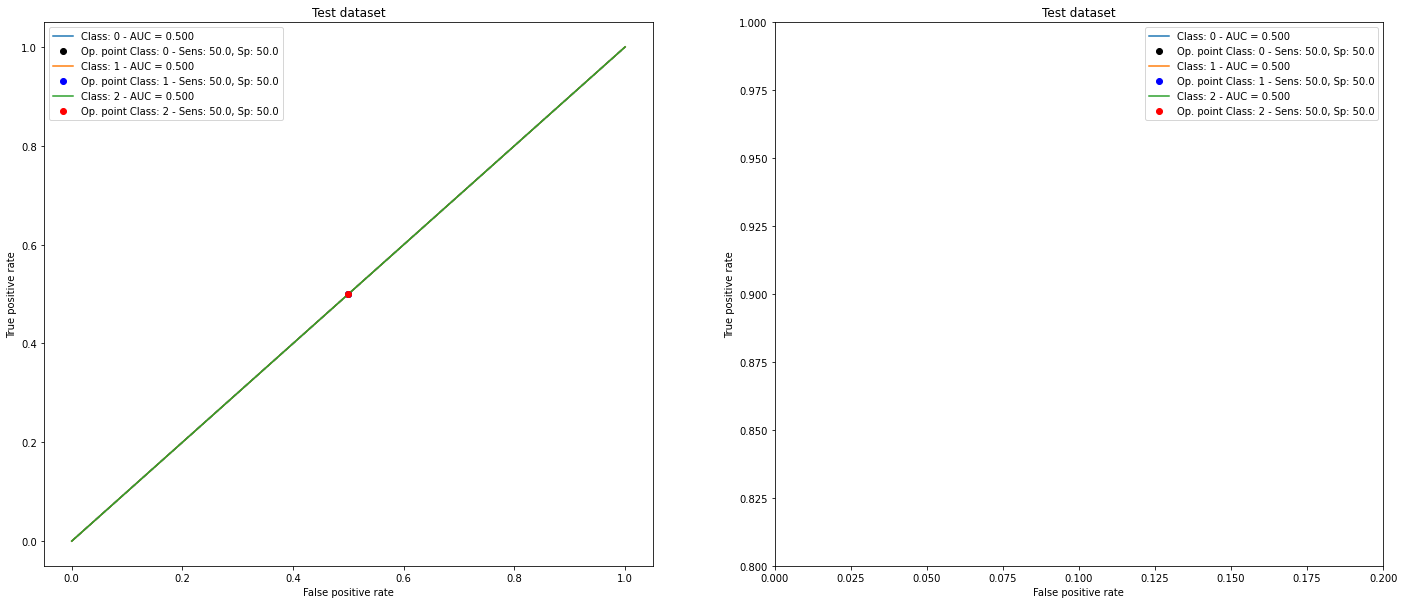

In [33]:
plot.plot_roc_curve(fpr_test, tpr_test, thr_test, 'Test dataset', list('012'), operative_threshold=operative_thresholds[-1], grid=False, show_points=False)

In [31]:
# Save model weights
model.save_weights(save_path)